6. The SHAP analysis is interesting, however it could be made stronger by looking into the correlations of features and/or the stability of SHAP scores for the same MTL model across different folds/seeds. Basically, are the differences in SHAP scores statistically significant?


In [1]:
import argparse
from datetime import datetime
from pathlib import Path
from warnings import filterwarnings

import lightning.pytorch as pl
import pandas as pd
import torch
import yaml
from tqdm import tqdm

from dataset import TCGA_Program_Dataset
from datasets_manager import TCGA_Balanced_Datasets_Manager, TCGA_Datasets_Manager
from lit_models import LitFullModel
from model import Classifier, Feature_Extractor, Graph_And_Clinical_Feature_Extractor, Task_Classifier
from utils import config_add_subdict_key, get_logger, override_n_genes, set_random_seed, setup_logging
import shap


import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
import numpy as np
import seaborn as sns

SEED = 1126
set_random_seed(SEED)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:


def create_models_and_optimizers(config: dict):
    models: dict[str, torch.nn.Module] = {}
    optimizers: dict[str, torch.optim.Optimizer] = {}

    # Setup models. Do not use getattr() for better IDE support.
    for model_name, kargs in config['models'].items():
        if model_name == 'Graph_And_Clinical_Feature_Extractor':
            models['feat_ext'] = Graph_And_Clinical_Feature_Extractor(**kargs)
        elif model_name == 'Feature_Extractor':
            models['feat_ext'] = Feature_Extractor(**kargs)
        elif model_name == 'Task_Classifier':
            models['clf'] = Task_Classifier(**kargs)
        elif model_name == 'Classifier':
            models['clf'] = Classifier(**kargs)
        else:
            raise ValueError(f'Unknown model type: {model_name}')

    # Setup optimizers. If the key is 'all', the optimizer will be applied to all models.
    for key, optim_dict in config['optimizers'].items():
        opt_name = next(iter(optim_dict))
        if key == 'all':
            params = [param for model in models.values() for param in model.parameters()]
            optimizers[key] = getattr(torch.optim, opt_name)(params, **optim_dict[opt_name])
        else:
            optimizers[key] = getattr(torch.optim, opt_name)(models[key].parameters(), **optim_dict[opt_name])

    # Add models' structure to config for logging. TODO: Prettify.
    for model_name, torch_model in models.items():
        config[f'model.{model_name}'] = str(torch_model)
    return models, optimizers

In [3]:

# Select a config file.

config_path = '/home/zow/Multi-Cancer/config/light/MTL_TCGA.yaml'
config = config_path
with open(config, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
override_n_genes(config)                                                    # For multi-task graph models.
config_name =config_path.split('/')[-1].split('.')[0]


In [4]:

# Setup logging.
setup_logging(log_path := f'Logs/{config_name}/{datetime.now():%Y-%m-%dT%H:%M:%S}/')
logger = get_logger(config_name)
logger.info(f'Using Random Seed {SEED} for this experiment')
get_logger('lightning.pytorch.accelerators.cuda', log_level='WARNING')      # Disable cuda logging.
filterwarnings('ignore', r'.*Skipping val loop.*')                          # Disable val loop warning.


[INFO]	Using Random Seed 1126 for this experiment


In [5]:

# Create dataset manager.
#here use torch lightning DS
data = {'TCGA_BLC': TCGA_Program_Dataset(**config['datasets'])}
if 'TCGA_Balanced_Datasets_Manager' == config['datasets_manager']['type']:
    manager = TCGA_Balanced_Datasets_Manager(datasets=data, config=config_add_subdict_key(config))
else:
    manager = TCGA_Datasets_Manager(datasets=data, config=config_add_subdict_key(config))


[INFO]	Creating a TCGA Program Dataset with 3 Projects...
[INFO]	All files are downloaded for TCGA-BRCA
[INFO]	Creating 1093 cases for TCGA-BRCA...
[INFO]	Using genomic tpm cache files created at 2024-02-23 10:53:54 for TCGA-BRCA
[INFO]	Using clinical cache files created at 2024-02-23 10:54:21 for TCGA-BRCA
[INFO]	Using vital status cache files created at 2024-02-23 10:54:29 for TCGA-BRCA
[INFO]	Using overall survival cache files created at 2024-02-23 10:54:37 for TCGA-BRCA
[INFO]	Using disease specific survival cache files created at 2024-02-23 10:54:46 for TCGA-BRCA
[INFO]	Using survival time cache files created at 2024-02-23 10:54:53 for TCGA-BRCA
[INFO]	Using primary site cache files created at 2024-02-23 10:55:06 for TCGA-BRCA
[INFO]	All files are downloaded for TCGA-LUAD
[INFO]	Creating 510 cases for TCGA-LUAD...
[INFO]	Using genomic tpm cache files created at 2024-02-23 11:41:50 for TCGA-LUAD
[INFO]	Using clinical cache files created at 2024-02-23 11:41:58 for TCGA-LUAD
[INFO]	U

TODO: get the avg from all batches for each fold, for a more stable representation

In [13]:

valid_results = []
# Cross validation.
all_shap_values_folds = []
all_project_ids = []
all_shap_values_df = pd.DataFrame()
for key, values in manager['TCGA_BLC']['dataloaders'].items():
    if isinstance(key, int) and config['cross_validation']:
        pass
        models, optimizers = create_models_and_optimizers(config)
        lit_model = LitFullModel(models, optimizers, config)
        trainer = pl.Trainer(                                               # Create sub-folders for each fold.
            default_root_dir="",#log_path,
            max_epochs=1,#['max_epochs'],
            log_every_n_steps=1,
            enable_model_summary=False,
            enable_checkpointing=False,
        )
        print(f'Fold {key}: saved in {log_path}')
        trainer.fit(lit_model, train_dataloaders=values['train'], val_dataloaders=values['valid'])

        
        for batchid, batch in enumerate(test):
            print("batchid", batchid)
            # Get the shap values
            gene_name_cols = list(range(0,20)) # 0 to 20
            cols = gene_name_cols + ['project_id'] + ['fold']
            batch_df = pd.DataFrame(columns=cols) 
            feat_extractor = models['feat_ext']
            genomic_feat_ext = feat_extractor.genomic_feature_extractor
            explainer = shap.DeepExplainer(genomic_feat_ext, batch[0][0])
            shap_values = explainer.shap_values(batch[0][0]) #(8, 128, 20)
            #aggregate shap values for the first dimension
            shap_values = np.array(shap_values).mean(axis=0) #(128, 20)
            print("shap  values shape", np.array(shap_values).shape)

            #all_shap_values_folds.append(np.array(shap_values))
            #all_project_ids.append(batch[0][3].numpy())
            batch_df[gene_name_cols] = shap_values
            batch_df['project_id'] = batch[0][3].numpy()
            batch_df["fold"] = key
            all_shap_values_df = all_shap_values_df.append(batch_df)
        
        # get one batch of data
        # batch = next(iter(train))
        # (genomic, clinical, index, project_id), (overall_survival, survival_time, vital_status) = batch
        # # get the shap values
        # feat_extractor = models['feat_ext']
        # genomic_feat_ext = feat_extractor.genomic_feature_extractor        
        # explainer = shap.DeepExplainer(genomic_feat_ext, genomic)
        # #separate according to project_id
        # project_id = project_id.numpy()
        # all_project_ids.append(project_id)


        #shap_values = explainer.shap_values(genomic)
        #all_shap_values_folds.append(np.array(shap_values))
        #print shape of shap values and project_id
        #print(np.array(shap_values).shape)
        #print(project_id.shape)
        
        
    elif key == 'train':
        train = values
    elif key == 'test':
        test = values


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Fold 0: saved in Logs/MTL_TCGA/2024-03-11T16:08:07/
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 24.29it/s, v_num=44, loss=0.571]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 24.18it/s, v_num=44, loss=0.571]
batchid 0


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 1


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 2


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 3


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


shap  values shape (29, 20)
Fold 1: saved in Logs/MTL_TCGA/2024-03-11T16:08:07/
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 26.11it/s, v_num=45, loss=0.561]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 26.01it/s, v_num=45, loss=0.561]
batchid 0


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 1


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 2


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 3


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


shap  values shape (29, 20)
Fold 2: saved in Logs/MTL_TCGA/2024-03-11T16:08:07/
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 24.29it/s, v_num=46, loss=0.689]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 24.15it/s, v_num=46, loss=0.689]
batchid 0


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 1


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 2


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 3


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


shap  values shape (29, 20)
Fold 3: saved in Logs/MTL_TCGA/2024-03-11T16:08:07/
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 25.97it/s, v_num=47, loss=0.632]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 25.81it/s, v_num=47, loss=0.632]
batchid 0


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 1


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 2


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (128, 20)
batchid 3


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap  values shape (29, 20)


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [6]:
#save all
#all_shap_values_df.to_csv("shap_values.csv")
#load all_shap_values_df
all_shap_values_df = pd.read_csv("shap_values.csv", index_col=0)

all_shap_values_df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,project_id,fold
0,-0.002774,-0.012157,0.074287,-0.000621,-0.004051,0.371087,-0.010527,0.024344,0.001005,-0.014518,...,-0.008294,-0.001862,0.015572,0.048073,-0.060261,0.081873,-0.038473,-0.004182,1,0
1,-0.009782,0.005917,0.063765,-0.006068,0.018710,-0.399934,-0.018723,0.004528,0.000136,-0.015481,...,-0.004931,-0.003958,-0.005053,-0.000170,-0.044361,-0.011524,-0.042405,-0.015997,0,0
2,0.019245,0.005481,-0.045618,0.013124,0.010659,0.192193,-0.015608,-0.005216,-0.000170,-0.013747,...,-0.000150,-0.004465,-0.004038,0.008192,-0.020902,-0.010037,-0.042547,-0.030337,0,0
3,-0.004037,0.001573,0.044628,-0.017309,-0.003532,0.308500,0.033014,0.021687,-0.000469,0.031067,...,0.004000,0.002411,-0.004921,-0.015002,-0.059324,-0.008109,0.092399,-0.024107,2,0
4,-0.005091,-0.009731,0.069764,0.001189,-0.001331,0.369444,-0.010673,0.014505,0.000309,-0.015286,...,-0.008415,0.002973,0.016673,0.062904,-0.061909,0.039560,-0.028888,-0.031344,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,-0.007524,0.063389,-0.054387,-0.000096,0.007587,0.390627,0.003919,0.017035,0.023477,-0.011614,...,-0.000567,0.007024,-0.254296,0.037323,0.048399,-0.139103,0.051985,0.022612,1,3
25,-0.009604,-0.015613,-0.000975,0.004352,-0.002401,-0.322070,-0.012469,-0.013276,0.002038,-0.013309,...,-0.002108,0.004580,0.028371,0.007370,0.026416,0.033775,0.080803,0.015387,0,3
26,0.002202,-0.014223,-0.007637,0.006098,-0.003383,-0.233631,-0.010946,-0.020316,0.001615,-0.011260,...,0.000142,0.007703,0.025865,0.027488,-0.005398,0.036827,0.067081,0.004590,0,3
27,0.005911,0.055333,-0.054037,0.000972,0.001367,0.391208,-0.007728,0.023249,0.004404,-0.012263,...,-0.005025,0.001831,0.004082,0.079507,0.049967,-0.047624,0.072734,0.011089,1,3


In [7]:
# separate according to project_id
BRCA_shap_values = all_shap_values_df[all_shap_values_df['project_id'] == 0]
COAD_shap_values = all_shap_values_df[all_shap_values_df['project_id'] == 2]
LUAD_shap_values = all_shap_values_df[all_shap_values_df['project_id'] == 1]

#drop project_id column
BRCA_shap_values = BRCA_shap_values.drop(columns = ['project_id'])
COAD_shap_values = COAD_shap_values.drop(columns = ['project_id'])
LUAD_shap_values = LUAD_shap_values.drop(columns = ['project_id'])

#relabel gene names

BRCA_genes = ['ESR1', 'EFTUD2', 'HSPA8', 'STAU1', 'SHMT2', 'ACTB', 'GSK3B', 'YWHAB', 'UBXN6', 'PRKRA', 'BTRC', 'DDX23', 'SSR1', 'TUBA1C', 'SNIP1', 'SRSF5', 'ERBB2', 'MKI67', 'PGR', 'PLAU']
LUAD_genes = ['HNRNPU', 'STAU1', 'KDM1A', 'SERBP1', 'DHX9', 'EMC1', 'SSR1', 'PUM1', 'CLTC', 'PRKRA', 'KRR1', 'OCIAD1', 'CDC73', 'SLC2A1', 'HIF1A', 'PKM', 'CADM1', 'EPCAM', 'ALCAM', 'PTK7']
COAD_genes =  ['HNRNPL', 'HNRNPU', 'HNRNPA1', 'ZBTB2', 'SERBP1', 'RPL4', 'HNRNPK', 'HNRNPR', 'TFCP2', 'DHX9', 'RNF4', 'PUM1', 'ABCC1', 'CD44', 'ALCAM', 'ABCG2', 'ALDH1A1', 'ABCB1', 'EPCAM', 'PROM1']


BRCA_shap_values.columns = BRCA_genes + ['fold']
COAD_shap_values.columns = COAD_genes + ['fold']
LUAD_shap_values.columns = LUAD_genes + ['fold']


In [8]:




BRCA_corr = BRCA_shap_values.corr()
COAD_corr = COAD_shap_values.corr()
LUAD_corr = LUAD_shap_values.corr()


BRCA_corr = BRCA_corr.drop(columns = ['fold'])
COAD_corr = COAD_corr.drop(columns = ['fold'])
LUAD_corr = LUAD_corr.drop(columns = ['fold'])

#drop fold row too
BRCA_corr = BRCA_corr.drop(['fold'])
COAD_corr = COAD_corr.drop(['fold'])
LUAD_corr = LUAD_corr.drop(['fold'])

In [9]:
# plot correlation matrix
%matplotlib inline

def plot_corr(corr, cancer):
    plt.figure(figsize=(10,10))
    #show only bottom triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, cmap='coolwarm', annot=False, mask = mask)
    plt.title('SHAP Value Correlation - ' + cancer)
    #save figure
    plt.savefig(f'correlation_matrix_SHAP_{cancer}.png')
    plt.show()


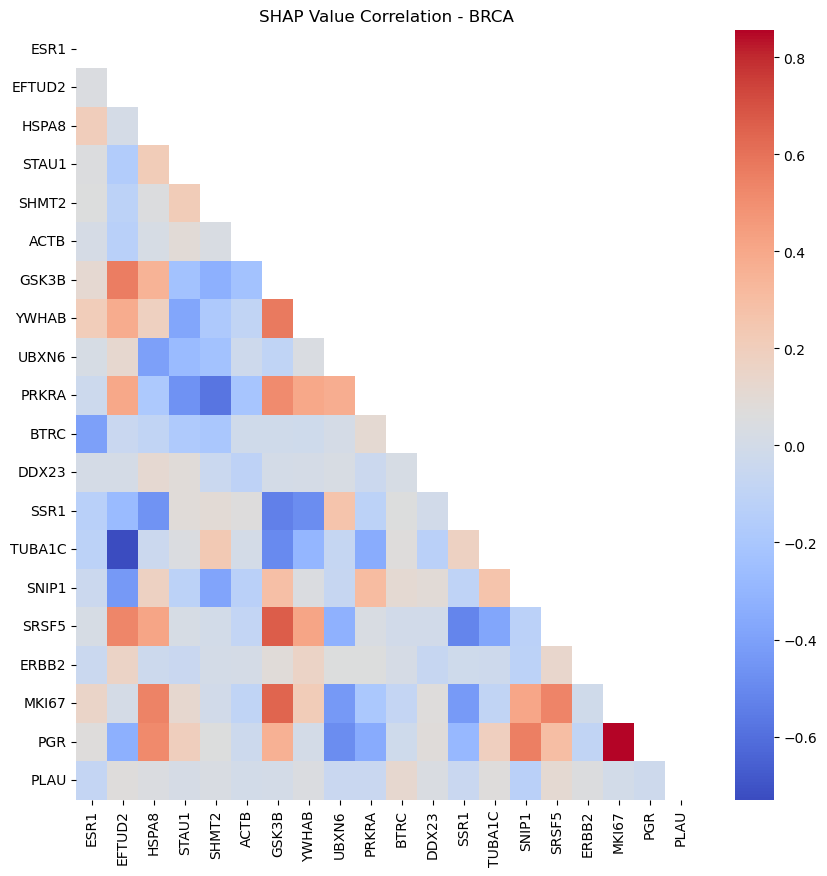

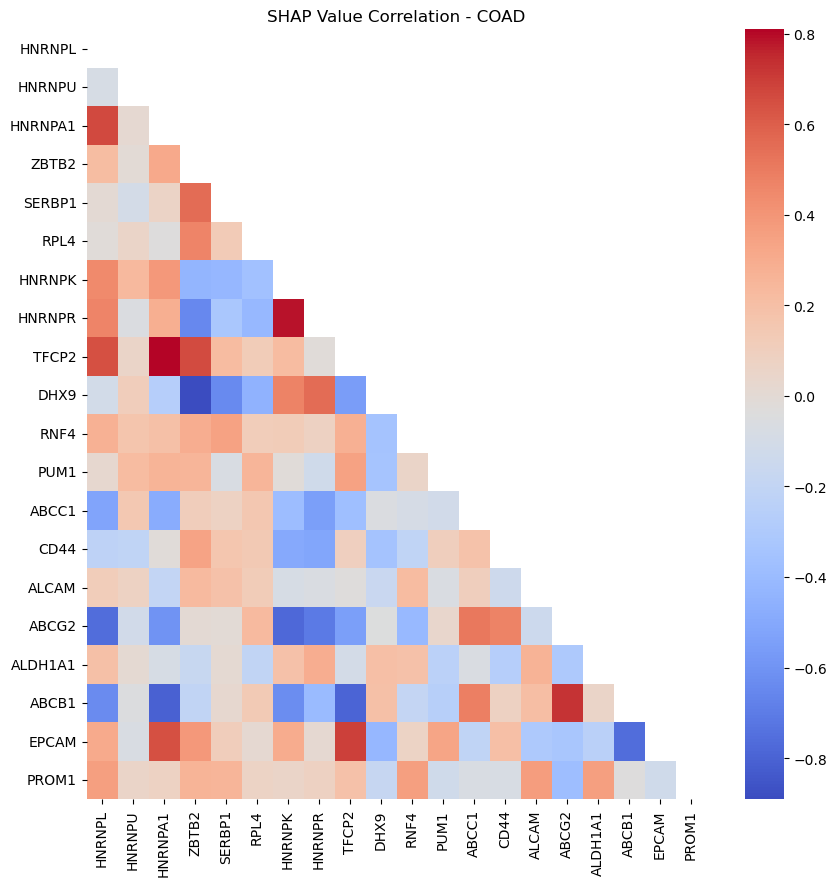

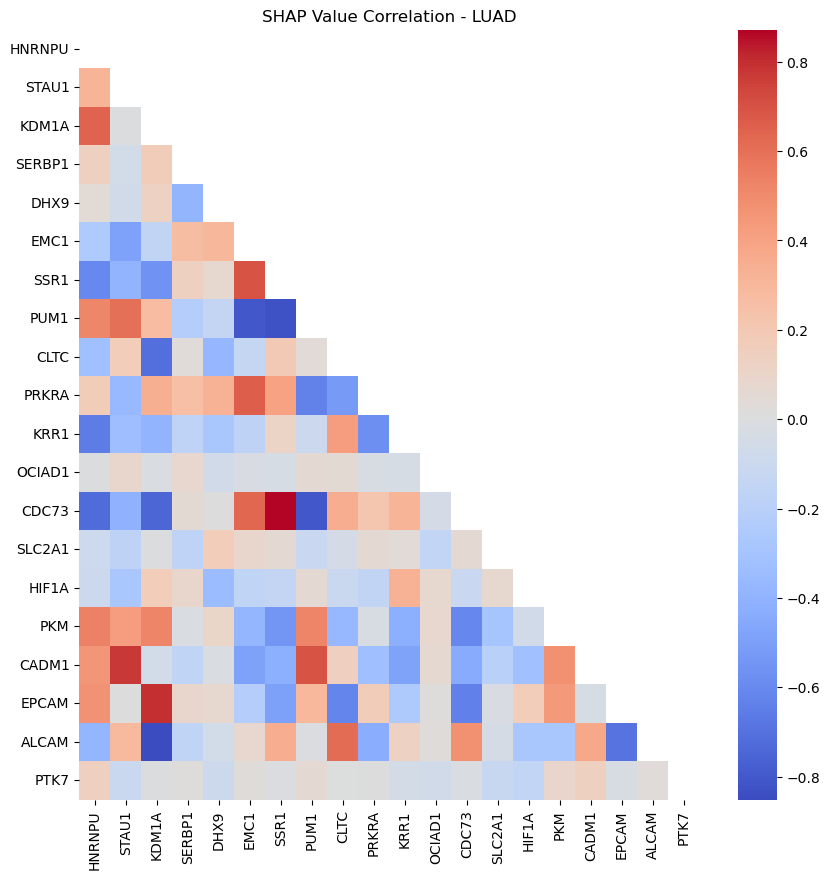

In [10]:
plot_corr(BRCA_corr, 'BRCA')
plot_corr(COAD_corr, 'COAD')
plot_corr(LUAD_corr, 'LUAD')

In [24]:


#calculate stability accross folds
# Calculate the mean and standard deviation of SHAP values for each feature across folds
def calculate_stability(shap_df):
    # separate according to fold and save in a list

    means = shap_df.groupby('fold').mean()
    stds = shap_df.groupby('fold').std()
    cv = stds / means  # Coefficient of Variation
    columns_names = shap_df.columns[:-1]

    # Convert to DataFrame for easier handling and interpretation
    stability_df = pd.DataFrame({
        'mean_shap': means.mean(axis=0),  # Mean across samples, then across folds
        'std_shap': stds.mean(axis=0),    # Std across samples, then across folds
        'cv_shap': cv.mean(axis=0)        # CV across samples, then across folds
    }, index=columns_names)  # Assuming feature names are the same across all folds

    # Sort by CV for features
    stability_df = stability_df.sort_values(by='cv_shap')
    return stability_df



# Plot the Coefficient of Variation (CV) for each feature
def plot_SHAP_stability(stability_df, dataset_name = ''):
    plt.figure(figsize=(10, 8))
    sns.barplot(x='cv_shap', y=stability_df.index, data=stability_df)
    plt.title('Coefficient of Variation of SHAP Values Across Folds for ' + dataset_name)
    plt.xlabel('Coefficient of Variation (CV)')
    plt.ylabel('Features')
    #plt.show()
    # save all plots as pdf
    plt.savefig('shap_stability_'+dataset_name+'.pdf')



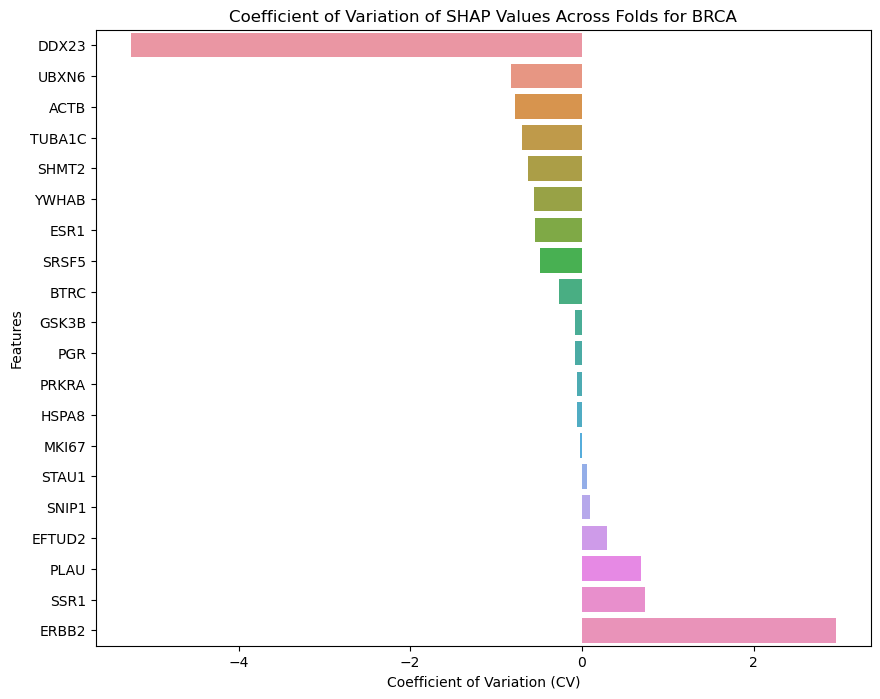

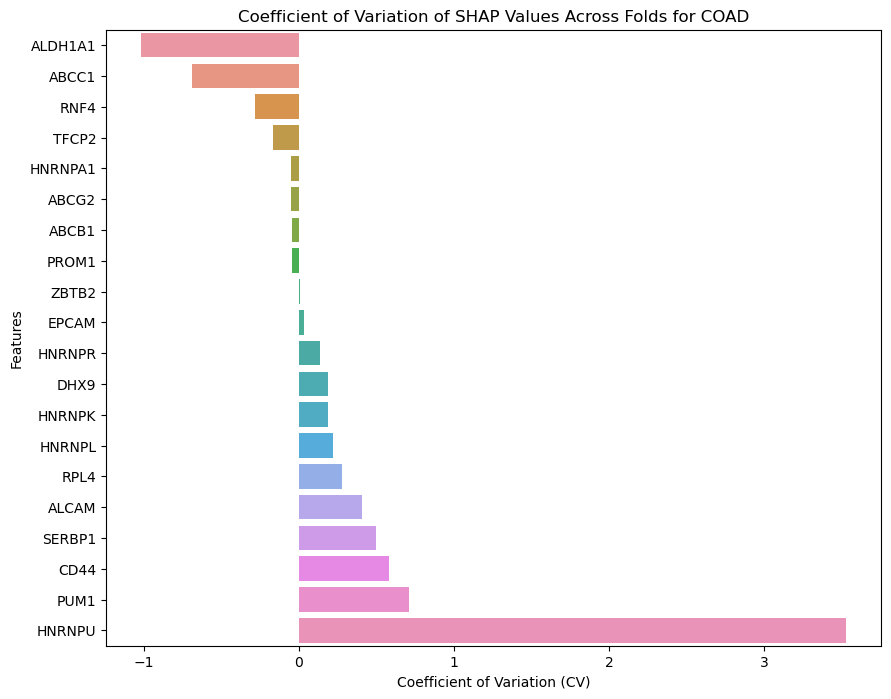

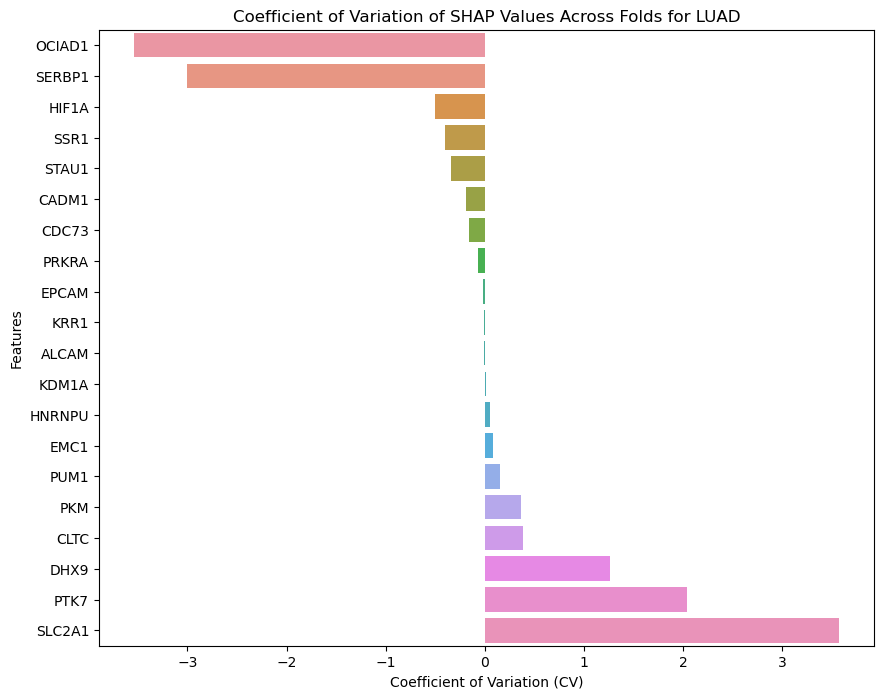

In [25]:


BRCA_stability = calculate_stability(BRCA_shap_values)
COAD_stability = calculate_stability(COAD_shap_values)
LUAD_stability = calculate_stability(LUAD_shap_values)


plot_SHAP_stability(BRCA_stability, 'BRCA')
plot_SHAP_stability(COAD_stability, 'COAD')
plot_SHAP_stability(LUAD_stability, 'LUAD')


plt.show()


Features with a high coefficient of variation (CV) are less stable across folds, meaning their importance varies more between different subsets of the data. In contrast, features with a low CV are more stable, suggesting consistent importance across different folds.

By identifying which features are stable and which are not, you can better understand the reliability of your model's feature importance scores and potentially identify areas where your model's performance might be improved with more consistent or representative training data.